In [360]:
import sys
import json
import csv
import yaml
import os

# can use the following as alternative way to load a large
#    set of environment variables; see below
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

In [361]:
# to add to the end of graph title
load_dotenv()

firstname = os.environ['firstname']
lastname = os.environ['lastname']
l4ID = os.environ['l4ID']

### 1. Listings Join Reviews Average Values per Year

In [362]:
# Load JSON data from the file
with open("listings_join_reviews.json", 'r') as file:
    data1 = json.load(file)
    json.dumps(data1, indent=4, sort_keys=True)

In [363]:
records1 = []
year_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no index",
    "__datetime_in_reviews__": "index datetime in reviews",
      "__id_in_listings__": "index id in listings",
      "__datetime_in_reviews__id_in_listings__": "index datetime in reviews and id in listings"
}

for year_key, combos in data1.items():
    # year_key ex："listing_join_reviews_2009"
    year = year_key.replace("listing_join_reviews_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records1.append(row)

# construct DataFrame
df_avg1 = pd.DataFrame.from_records(records1)
df_avg1 = df_avg1.rename(columns=key_labels)
df_avg1 = df_avg1.set_index("year")
df_avg1 = df_avg1.astype(float)


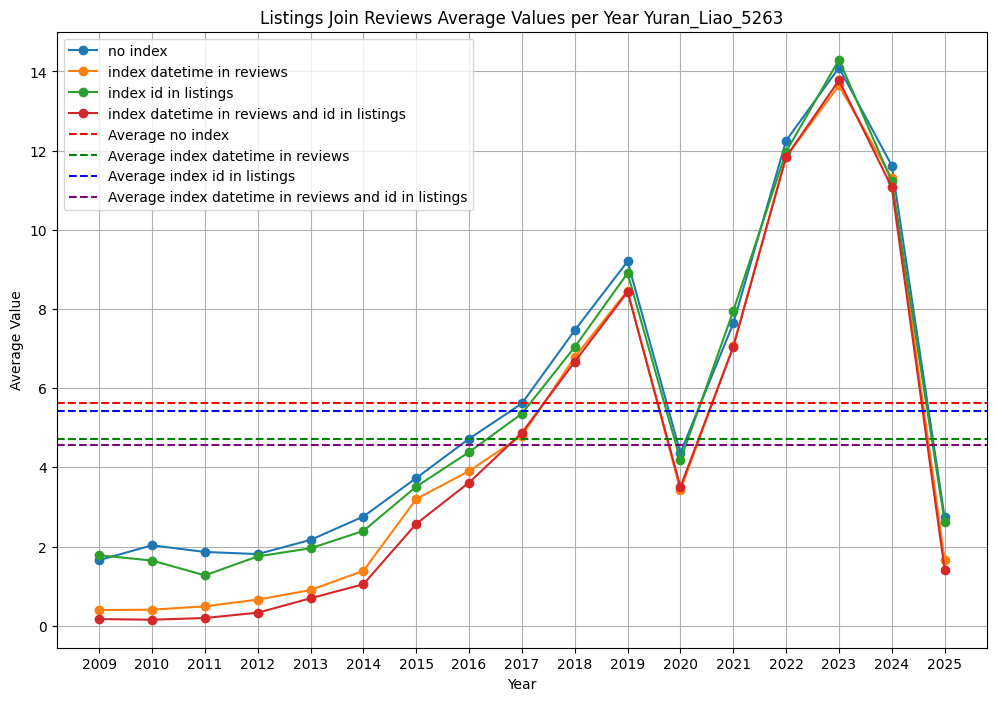

In [364]:
plt.figure(figsize=(12, 8))
for label in key_labels.values():
    plt.plot(df_avg1.index, df_avg1[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(key_labels.values()):
    avg_value = df_avg1[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Listings Join Reviews Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 2.Listings Join Reviews STD Values per Year

In [365]:
records2 = []

for year_key, combos in data1.items():
    # year_key ex："listing_join_reviews_2009"
    year = year_key.replace("listing_join_reviews_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records2.append(row)

# construct DataFrame
df_std2 = pd.DataFrame.from_records(records2)
df_std2 = df_std2.rename(columns=key_labels)
df_std2 = df_std2.set_index("year")
df_std2 = df_std2.astype(float)

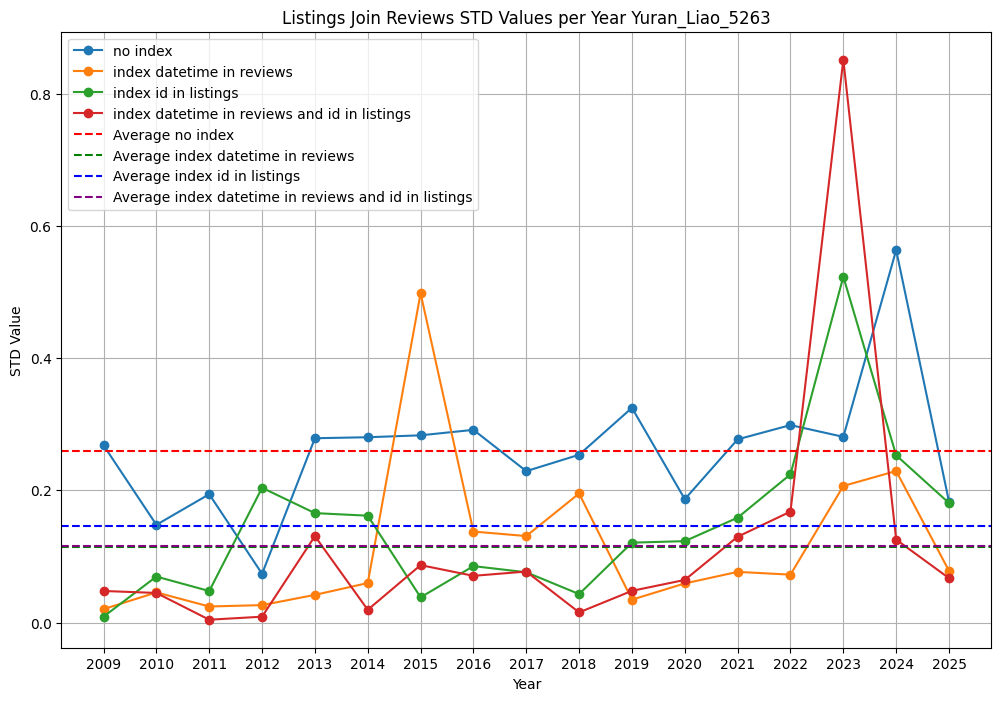

In [366]:
plt.figure(figsize=(12, 8))

for label in key_labels.values():
    plt.plot(df_std2.index, df_std2[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(key_labels.values()):
    avg_value = df_std2[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Listings Join Reviews STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 3. Text Search HORRIBLE Average Values per Year

In [367]:
# Load JSON data from the file
with open("text_search_query.json", 'r') as file:
    data2 = json.load(file)
    json.dumps(data2, indent=4, sort_keys=True)

In [368]:
records3 = []
year_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__comments_tsv_in_reviews__": "only_tsv_index",
    "__datetime_in_reviews__": "only_datetime_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_tsv_index"
}

In [369]:
# only keep the keys that start with "horrible_"
for year_key, combos in data2.items():
    if not year_key.startswith("horrible_"):
        continue
    year = year_key.replace("horrible_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records3.append(row)

df_horrible_avg = pd.DataFrame.from_records(records3)
df_horrible_avg = df_horrible_avg.rename(columns=key_labels)
df_horrible_avg = df_horrible_avg.set_index("year")
df_horrible_avg = df_horrible_avg.astype(float)


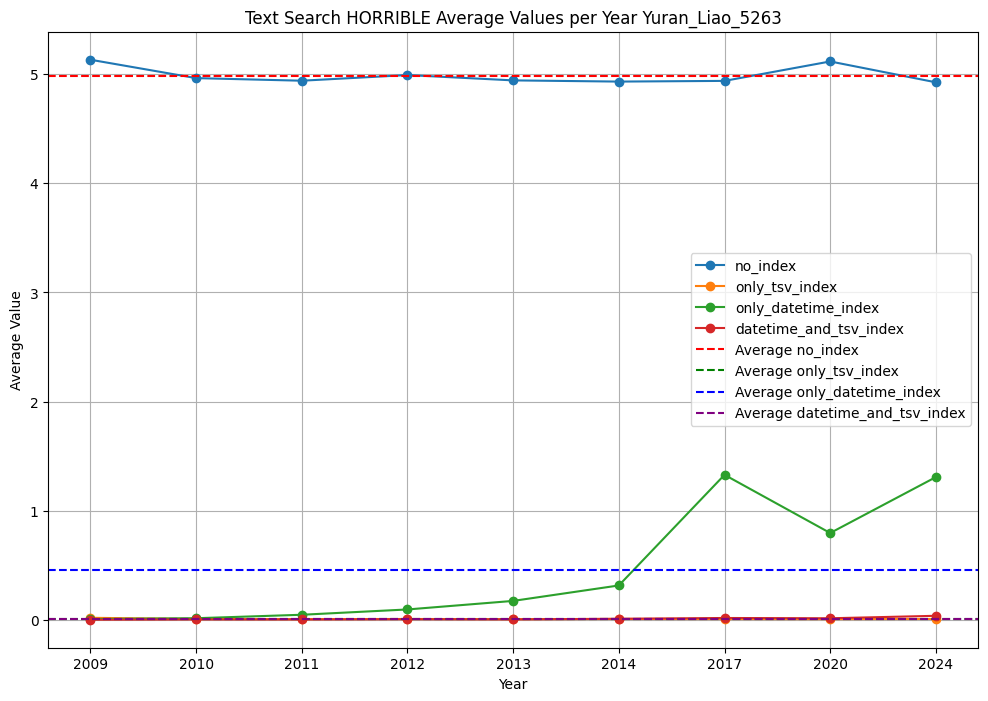

In [370]:
plt.figure(figsize=(12, 8))
for label in df_horrible_avg.columns:
    plt.plot(df_horrible_avg.index, df_horrible_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_horrible_avg.columns):
    avg_value = df_horrible_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search HORRIBLE Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 4. Text Search HORRIBLE STD Values per Year

In [371]:
records4 = []
year_list = []

# only keep the keys that start with "horrible_"
for year_key, combos in data2.items():
    if not year_key.startswith("horrible_"):
        continue
    year = year_key.replace("horrible_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records4.append(row)

df_horrible_std = pd.DataFrame.from_records(records4)
df_horrible_std = df_horrible_std.rename(columns=key_labels)
df_horrible_std = df_horrible_std.set_index("year")
df_horrible_std = df_horrible_std.astype(float)

print(df_horrible_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    0.1944          0.0204               0.0036                  0.0003
2010    0.0277          0.0055               0.0035                  0.0027
2011    0.0269          0.0057               0.0064                  0.0017
2012    0.0500          0.0049               0.0165                  0.0038
2013    0.0295          0.0072               0.0309                  0.0022
2014    0.0865          0.0052               0.0507                  0.0043
2017    0.0702          0.0052               0.0046                  0.0009
2020    0.1992          0.0078               0.0037                  0.0044
2024    0.1027          0.0029               0.0052                  0.0045


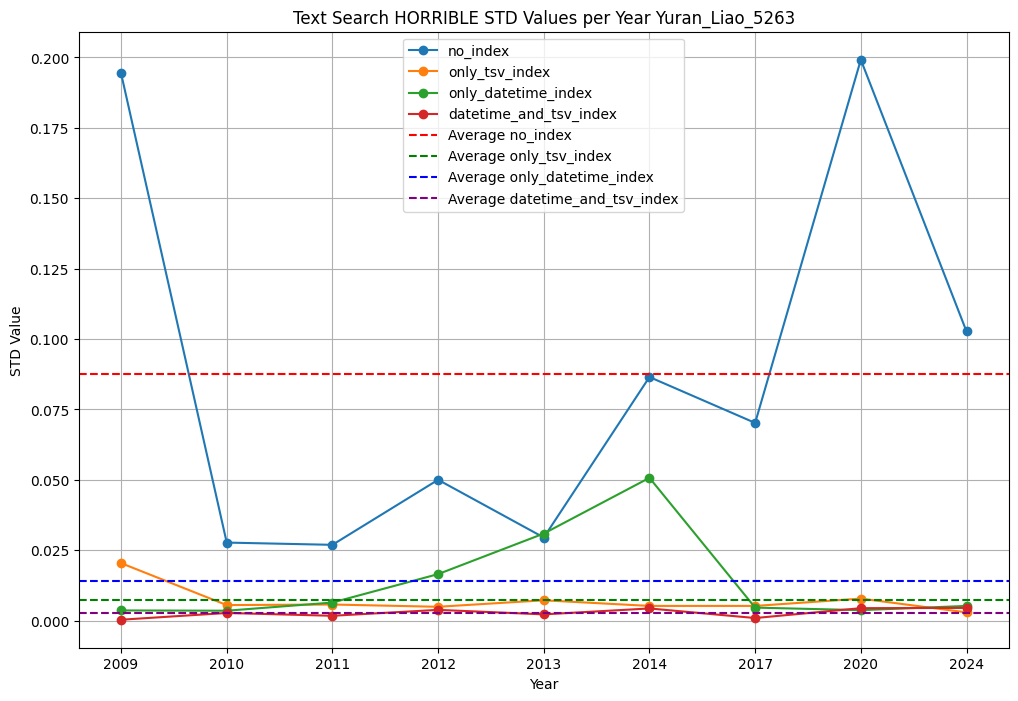

In [372]:
plt.figure(figsize=(12, 8))
for label in df_horrible_std.columns:
    plt.plot(df_horrible_std.index, df_horrible_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_horrible_std.columns):
    avg_value = df_horrible_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search HORRIBLE STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 5. Text Search AWESOME Average Values per Year

In [373]:
records5 = []
year_list = []

# only keep the keys that start with "awesome_"
for year_key, combos in data2.items():
    if not year_key.startswith("awesome_"):
        continue
    year = year_key.replace("awesome_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records5.append(row)

df_awesome_avg = pd.DataFrame.from_records(records5)
df_awesome_avg = df_awesome_avg.rename(columns=key_labels)
df_awesome_avg = df_awesome_avg.set_index("year")
df_awesome_avg = df_awesome_avg.astype(float)

print(df_awesome_avg)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    5.4954          0.3107               0.0056                  0.0092
2010    5.1330          0.2965               0.0143                  0.0131
2011    5.0701          0.2873               0.0462                  0.0123
2012    5.1586          0.2866               0.0937                  0.0132
2013    5.1408          0.2890               0.1746                  0.0139
2014    5.2374          0.2991               0.3253                  0.0138
2017    5.2879          0.3127               1.3731                  0.0268
2020    5.1212          0.2890               0.8052                  0.0269
2024    5.1796          0.3000               1.3728                  0.0802


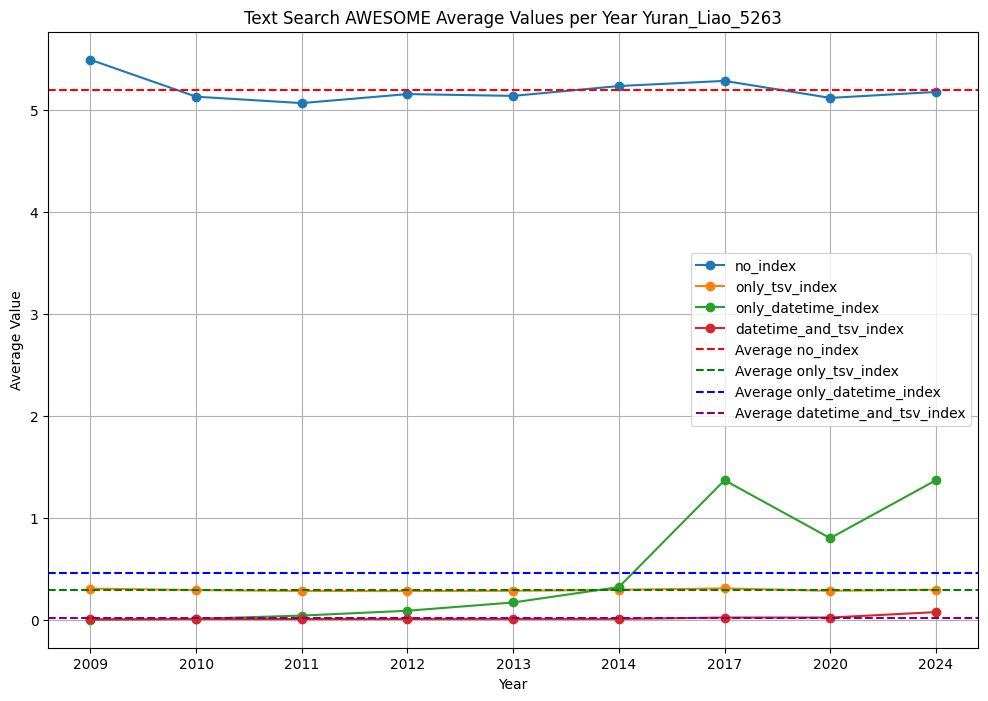

In [374]:
plt.figure(figsize=(12, 8))
for label in df_awesome_avg.columns:
    plt.plot(df_awesome_avg.index, df_awesome_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_awesome_avg.columns):
    avg_value = df_awesome_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search AWESOME Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 6. Text Search AWESOME STD Values per Year

In [375]:
records6 = []
year_list = []

# only keep the keys that start with "awesome_"
for year_key, combos in data2.items():
    if not year_key.startswith("awesome_"):
        continue
    year = year_key.replace("awesome_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records6.append(row)

df_awesome_std = pd.DataFrame.from_records(records6)
df_awesome_std = df_awesome_std.rename(columns=key_labels)
df_awesome_std = df_awesome_std.set_index("year")
df_awesome_std = df_awesome_std.astype(float)

print(df_awesome_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    0.0458          0.0052               0.0045                  0.0029
2010    0.0561          0.0039               0.0030                  0.0036
2011    0.0567          0.0042               0.0094                  0.0019
2012    0.0654          0.0045               0.0163                  0.0028
2013    0.0300          0.0033               0.0283                  0.0008
2014    0.0329          0.0121               0.0488                  0.0051
2017    0.0536          0.0046               0.0134                  0.0033
2020    0.1125          0.0071               0.0070                  0.0014
2024    0.1834          0.0143               0.0192                  0.0228


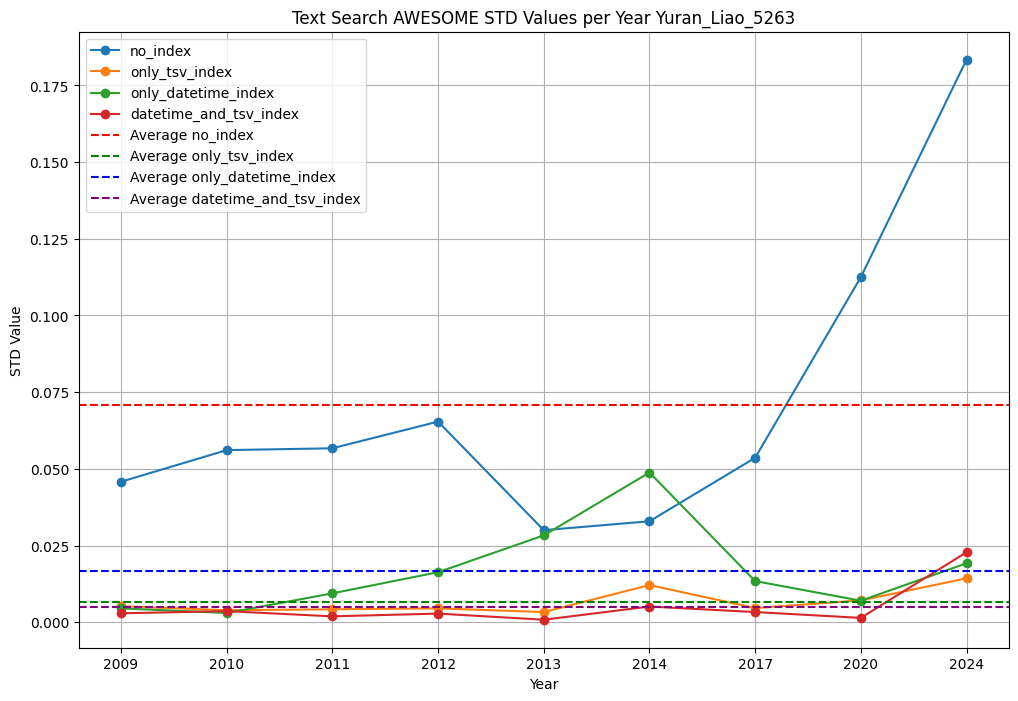

In [376]:
plt.figure(figsize=(12, 8))
for label in df_awesome_std.columns:
    plt.plot(df_awesome_std.index, df_awesome_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_awesome_std.columns):
    avg_value = df_awesome_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search AWESOME STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 7. Text Search APARTMENT Average Values per Year

In [377]:
records7 = []
year_list = []

# only keep the keys that start with "apartment_"
for year_key, combos in data2.items():
    if not year_key.startswith("apartment_"):
        continue
    year = year_key.replace("apartment_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records7.append(row)

df_apartment_avg = pd.DataFrame.from_records(records7)
df_apartment_avg = df_apartment_avg.rename(columns=key_labels)
df_apartment_avg = df_apartment_avg.set_index("year")
df_apartment_avg = df_apartment_avg.astype(float)

print(df_apartment_avg)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    5.0571          1.6231               0.0056                  0.0663
2010    5.0081          1.5616               0.0149                  0.0687
2011    5.0068          1.5654               0.0471                  0.0712
2012    5.0677          1.5491               0.0945                  0.0751
2013    5.0308          1.5651               0.1682                  0.0857
2014    5.0978          1.5728               0.3204                  0.1035
2017    5.0735          1.5901               1.3641                  0.2499
2020    5.0344          1.5487               0.8265                  0.2078
2024    5.0347          1.5906               1.3466                  0.6615


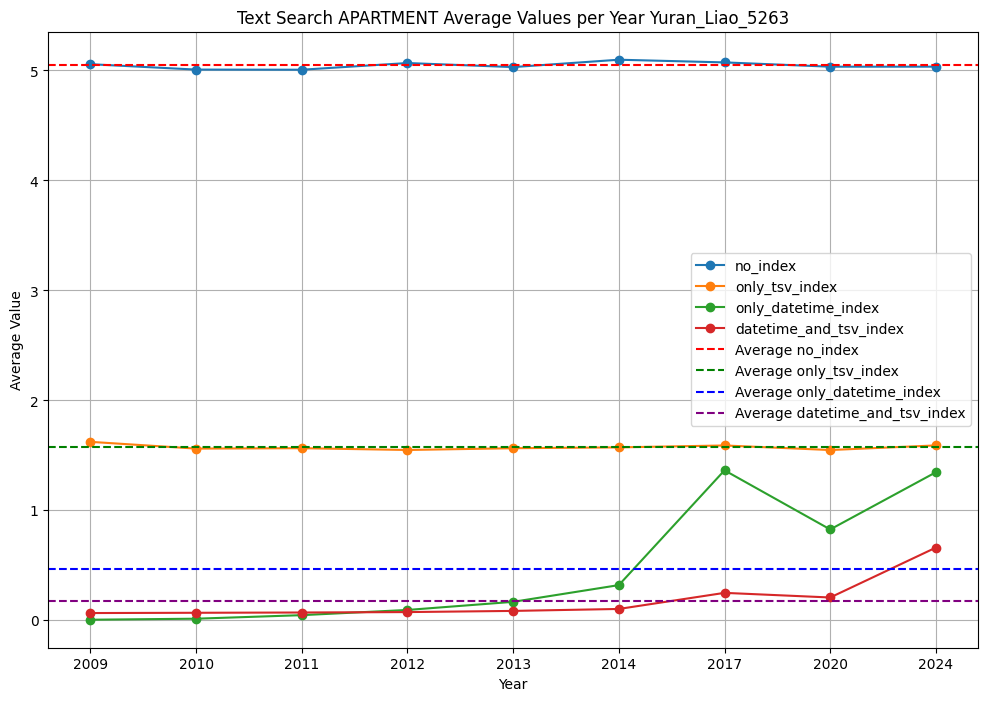

In [378]:
plt.figure(figsize=(12, 8))
for label in df_apartment_avg.columns:
    plt.plot(df_apartment_avg.index, df_apartment_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_apartment_avg.columns):
    avg_value = df_apartment_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search APARTMENT Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 8. Text Search APARTMENT STD Values per Year

In [379]:
records8 = []
year_list = []

# only keep the keys that start with "apartment_"
for year_key, combos in data2.items():
    if not year_key.startswith("apartment_"):
        continue
    year = year_key.replace("apartment_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records8.append(row)

df_apartment_std = pd.DataFrame.from_records(records8)
df_apartment_std = df_apartment_std.rename(columns=key_labels)
df_apartment_std = df_apartment_std.set_index("year")
df_apartment_std = df_apartment_std.astype(float)

print(df_apartment_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    0.0376          0.1027               0.0032                  0.0009
2010    0.0360          0.0324               0.0020                  0.0026
2011    0.0607          0.0155               0.0078                  0.0017
2012    0.0322          0.0106               0.0196                  0.0011
2013    0.0806          0.0065               0.0295                  0.0020
2014    0.0343          0.0124               0.0552                  0.0025
2017    0.1445          0.0223               0.0154                  0.0513
2020    0.1688          0.0113               0.0396                  0.0591
2024    0.1014          0.0117               0.0077                  0.0132


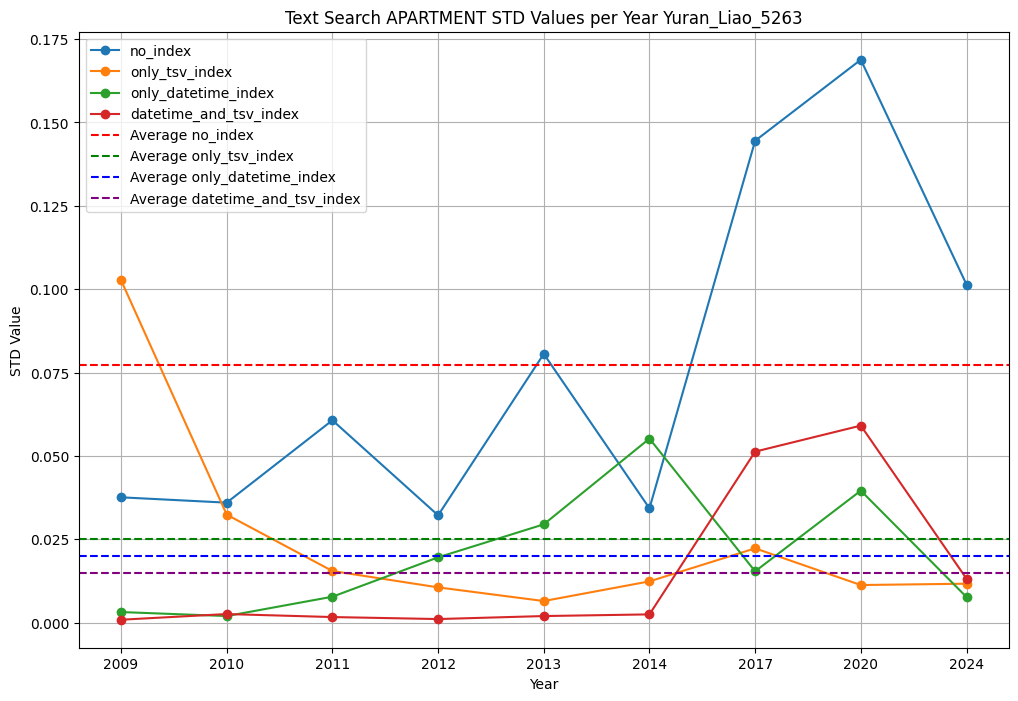

In [380]:
plt.figure(figsize=(12, 8))
for label in df_apartment_std.columns:
    plt.plot(df_apartment_std.index, df_apartment_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_apartment_std.columns):
    avg_value = df_apartment_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search APARTMENT STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 9. Update Datetimes Query Average Values per Location

In [381]:
# Load JSON data from the file
with open("update_datetimes_query.json", 'r') as file:
    data = json.load(file)
    json.dumps(data, indent=4, sort_keys=True)

In [382]:
records = []
location_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neighbourhood_index",
    "__datetime_in_reviews__neigh_in_listings__": "datetime_and_neighbourhood_index"
}

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(records)

# rename columns by using the key_labels dictionary
loc_avg = loc_std.rename(columns=key_labels)

# set location as index
loc_avg = loc_avg.set_index("location")

print(loc_avg)

                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.7938          0.7057               1.7444   
Fort Hamilton         2.4823          2.6769               2.6032   
Long Island City      3.5231          3.4754               3.4814   
Bedford-Stuyvesant    6.9483          6.4764               6.2526   
Staten Island         2.9370          3.5937               3.6233   
Bronx                 4.3518          4.1495               4.3158   
Queens               14.9064         14.1570              14.1154   
Manhattan            24.4415         24.3724              23.8161   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               2.0919  
Fort Hamilton                                 2.5360  
Long Island City                              3.5333  
Bedford-Stuyvesant                

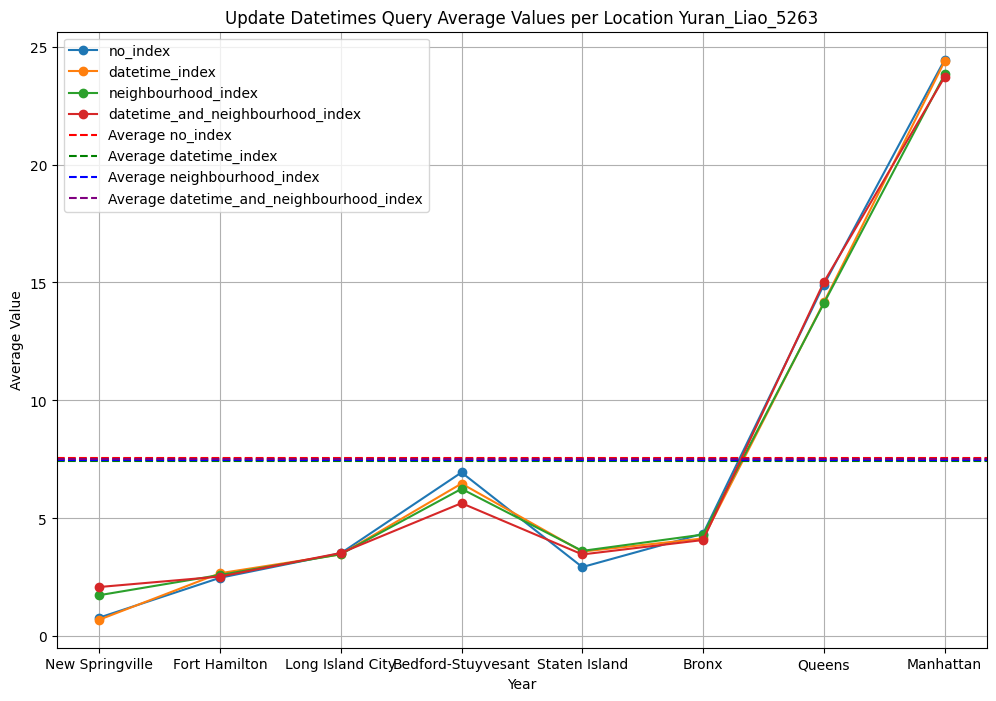

In [383]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_avg.index, loc_avg[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query Average Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 10. Update Datetimes Query STD Values per Location

In [384]:
record_std = []

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    record_std.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(record_std)

# rename columns by using the key_labels dictionary
loc_std = loc_std.rename(columns=key_labels)

# set location as index
loc_std = loc_std.set_index("location")

print(loc_std)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.6084          0.0400               0.6505   
Fort Hamilton         0.4395          0.4100               0.4451   
Long Island City      0.5684          0.5981               0.5283   
Bedford-Stuyvesant    1.4342          1.5453               1.3179   
Staten Island         0.5912          0.4280               0.4646   
Bronx                 0.4518          0.4208               0.4718   
Queens                3.0107          1.8317               3.2268   
Manhattan             6.6517          5.1987               3.8361   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               0.1383  
Fort Hamilton                                 0.3663  
Long Island City                              0.5740  
Bedford-Stuyvesant                

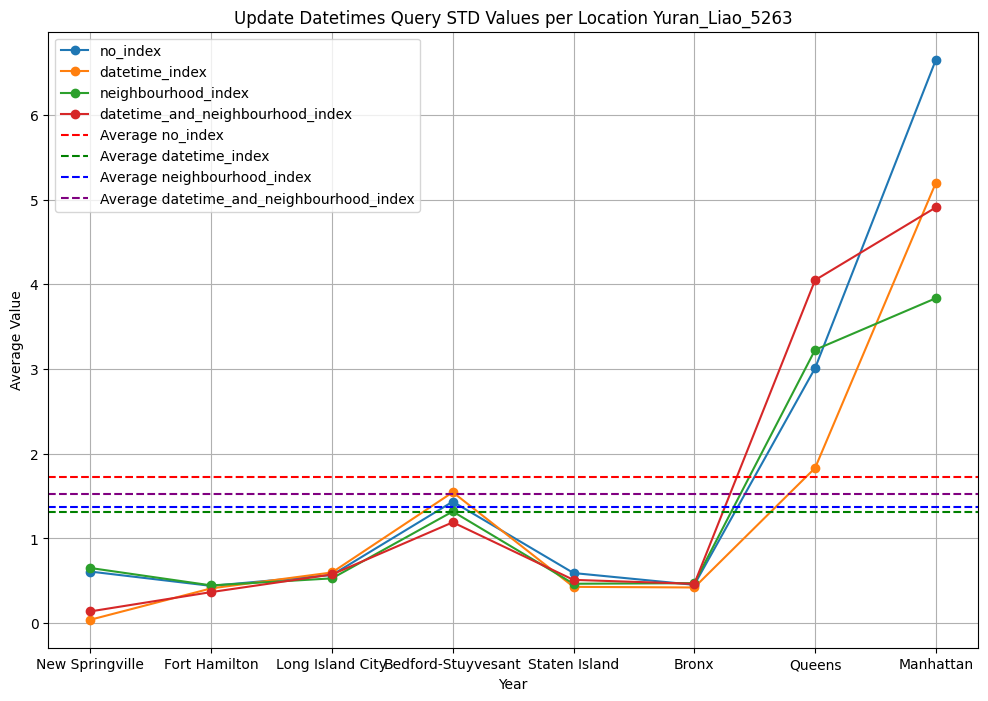

In [385]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_std.index, loc_std[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query STD Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()